In [68]:
import yelpapi
import json
import requests
from  pprint import  pprint
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

#reading in county data
counties=pd.read_csv("acs2015_county_data.csv")
counties["county_string"] = counties["County"] + " County, " + counties["State"]
listofcounties = counties["county_string"].tolist()
#reading in zipcodes
zipcodes=pd.read_csv("zip_codes_states.csv")
zipcodes["county_string"] = zipcodes["county"] + " County, " + zipcodes["state"]
listofzipcodes=zipcodes["county_string"].unique().tolist()
counties.to_csv("counties.csv")
zipcodes.to_csv("zcs.csv")
fullcountylist = list(set(listofcounties) & set(listofzipcodes))
counties.head(1)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,county_string
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6,"Autauga County, Alabama"


In [69]:
#creating regions
WC = ["Washington","Oregon","California","Nevada","Idaho"]
MW = ["Montana","Wyoming","North Dakota","South Dakota","Nebraska","Kansas","Minnesota","Iowa","Missouri",
      "Wisconsin","Illinois","Michigan","Indiana","Ohio","Kentucky"]
SW = ["Arizona","Utah","Colorado","New Mexico","Oklahoma","Texas"]
SE = ["Arkansas","Louisiana","Mississippi","Alabama","Tennessee","Virginia","West Virginia","North Carolina","South Carolina","Georgia","Florida"]
NE = ["District of Columbia","Pennsylvania","Maryland","Delaware","New Jersey","New York","Maine","New Hampshire","Vermont","Massachusetts","Rhode Island","Connecticut"]
counties["Region"]= np.where(counties["State"].isin(WC),'WC',
                    np.where(counties["State"].isin(MW),'MW',
                    np.where(counties["State"].isin(SW),'SW',
                    np.where(counties["State"].isin(SE),'SE',
                    np.where(counties["State"].isin(NE),'NE', 
                             'other')))))

In [70]:
#counties.groupby(["Region"]).sum()["TotalPop"]
cdf = pd.DataFrame(counties,columns=["county_string","Region"])
WClist = (cdf.groupby("Region").get_group("WC")["county_string"]).tolist()
MWlist = (cdf.groupby("Region").get_group("MW")["county_string"]).tolist()
SWlist = (cdf.groupby("Region").get_group("SW")["county_string"]).tolist()
SElist = (cdf.groupby("Region").get_group("SE")["county_string"]).tolist()
NElist = (cdf.groupby("Region").get_group("NE")["county_string"]).tolist()

sample_list = []
sample_list.extend(random.sample(list(set(WClist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(MWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SElist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(NElist) & set(fullcountylist)),2))
sample_list

['San Luis Obispo County, California',
 'Clark County, Washington',
 'Scott County, Missouri',
 'Alexander County, Illinois',
 'Kane County, Utah',
 'Scurry County, Texas',
 'Smyth County, Virginia',
 'Horry County, South Carolina',
 'Middlesex County, Massachusetts',
 'Cape May County, New Jersey']

In [72]:
res_df = pd.DataFrame(columns=["name","zipcode","county_string","rating","review_count","category","price"])
res_df

,name,zipcode,county_string,rating,review_count,category,price


In [73]:
r = 0
for c in sample_list:
    county_string = str(c)
    for term in ["Italian","Mexican","Chinese","American","Indian"]:
        #we are allowed 5000 queries per 24 hours. if we run out, we can create another. till then, use this
        yelpkey="IXRN_1GI8f8J9Kj5O5GciqeyFSWR5RMh41_rADGy1KrtQ5ZABGGZEkWwot5mOka0NlzlNxXPmzYXLWk88oOV0N_YxD1MSW4kQRfJnFrwfHLtKrr2HcsjLo6uWBzAWnYx"
        try:
            offset=0
            for loopcount in range(5):
                
                response = requests.get(url="https://api.yelp.com/v3/businesses/search", 
                       params= {"location": county_string,"term": term, "limit":"50", "offset": offset}, 
                       headers={'Authorization': 'bearer %s' % yelpkey})
                responsejson = response.json()
                offset += 50
                try:
                    count=0
            
                    for x in range(0,49):
                        for y in range(0,len(responsejson["businesses"][x]["categories"])):
                            
                            if ((str(responsejson["businesses"][x]["categories"][y]["title"]).startswith(str(term))) and 
                                (responsejson["businesses"][x]["review_count"] > 0)):
                        
                                zc = int(responsejson["businesses"][x]["location"]["zip_code"])
                                if (zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0]== county_string):
                            
#                                     print("\n",responsejson["businesses"][x]["name"],
#                                           responsejson["businesses"][x]["location"]["zip_code"],
#                                           zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0],
#                                           responsejson["businesses"][x]["rating"],
#                                           responsejson["businesses"][x]["review_count"],
#                                           responsejson["businesses"][x]["categories"][y]["title"])
                            
                                    res_df.loc[r]=[responsejson["businesses"][x]["name"],
                                          str(zc),
                                          county_string,
                                          responsejson["businesses"][x]["rating"],
                                          responsejson["businesses"][x]["review_count"],
                                          term,
                                          responsejson["businesses"][x]["price"]]
                                          #responsejson["businesses"][x]["price"]]
                                    count += 1
                                    r += 1
                except:
                    break
    
                print("End of list. Found", count, term, "restaurants in", county_string)
        except:
            break


End of list. Found 32 Italian restaurants in San Luis Obispo County, California
End of list. Found 46 Mexican restaurants in San Luis Obispo County, California
End of list. Found 12 Italian restaurants in Clark County, Washington
End of list. Found 2 Italian restaurants in Clark County, Washington
End of list. Found 0 Italian restaurants in Alexander County, Illinois
End of list. Found 0 Mexican restaurants in Alexander County, Illinois
End of list. Found 0 Mexican restaurants in Alexander County, Illinois
End of list. Found 0 Chinese restaurants in Alexander County, Illinois
End of list. Found 4 American restaurants in Kane County, Utah
End of list. Found 38 Italian restaurants in Horry County, South Carolina
End of list. Found 35 Italian restaurants in Middlesex County, Massachusetts
End of list. Found 32 Chinese restaurants in Middlesex County, Massachusetts
End of list. Found 18 Chinese restaurants in Middlesex County, Massachusetts
End of list. Found 20 Chinese restaurants in Midd

In [74]:

res_df.to_csv("output1804042050.csv")
res_df.price.replace(["$","$$","$$$","$$$$"],[1,2,3,4],inplace=True)
res_df.head()



,name,zipcode,county_string,rating,review_count,category,price
0,Giuseppe's Cucina Italiana,93449,"San Luis Obispo County, California",4.0,716,Italian,2
1,Rosa's Italian Restaurant,93449,"San Luis Obispo County, California",4.0,639,Italian,2
2,Buona Tavola,93446,"San Luis Obispo County, California",4.0,512,Italian,2
3,Giuseppe's Cucina Rustica,93401,"San Luis Obispo County, California",4.0,548,Italian,2
4,Buona Tavola,93401,"San Luis Obispo County, California",4.0,461,Italian,2


In [136]:
#Merged the data with the counties CSV file

merged= pd.merge(res_df,counties, how='left', on="county_string",)

# created DataFrame with limited fields
newdf1= merged[['category', 'Region','county_string', 'price','rating', 'review_count','Income']]
print(newdf1.columns)
# summing the review count
gdf= newdf1.groupby(['category', 'Region','price','rating','Income'])['review_count'].sum()
gdf.head(200)
gdf.to_csv('newdf1.csv', header=True)
newdf = pd.read_csv("newdf1.csv")
newdf.head()

Index(['name', 'zipcode', 'county_string', 'rating', 'review_count',
       'category', 'price', 'CensusId', 'State', 'County', 'TotalPop', 'Men',
       'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'Citizen', 'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr',
       'Poverty', 'ChildPoverty', 'Professional', 'Service', 'Office',
       'Construction', 'Production', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork',
       'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment', 'Region'],
      dtype='object')
Index(['category', 'Region', 'county_string', 'price', 'rating',
       'review_count', 'Income'],
      dtype='object')


,category,Region,price,rating,Income,review_count
0,American,MW,1,4.0,39162.0,7
1,American,MW,1,4.5,39162.0,20
2,American,MW,2,4.0,39162.0,459
3,American,MW,2,4.5,39162.0,10
4,American,NE,1,4.5,57637.0,51


In [173]:
newdf5=newdf[["category","Region","price","rating"]]
# New column Income calc expressing the income in thousands for showing better on a bar plot
newdf6= newdf[["category","Region","review_count"]]
newdf6["Incomecalc"]= newdf["Income"]/100

newdf5.head()

C:\Users\omsairam\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,category,Region,price,rating
0,American,MW,1,4.0
1,American,MW,1,4.5
2,American,MW,2,4.0
3,American,MW,2,4.5
4,American,NE,1,4.5


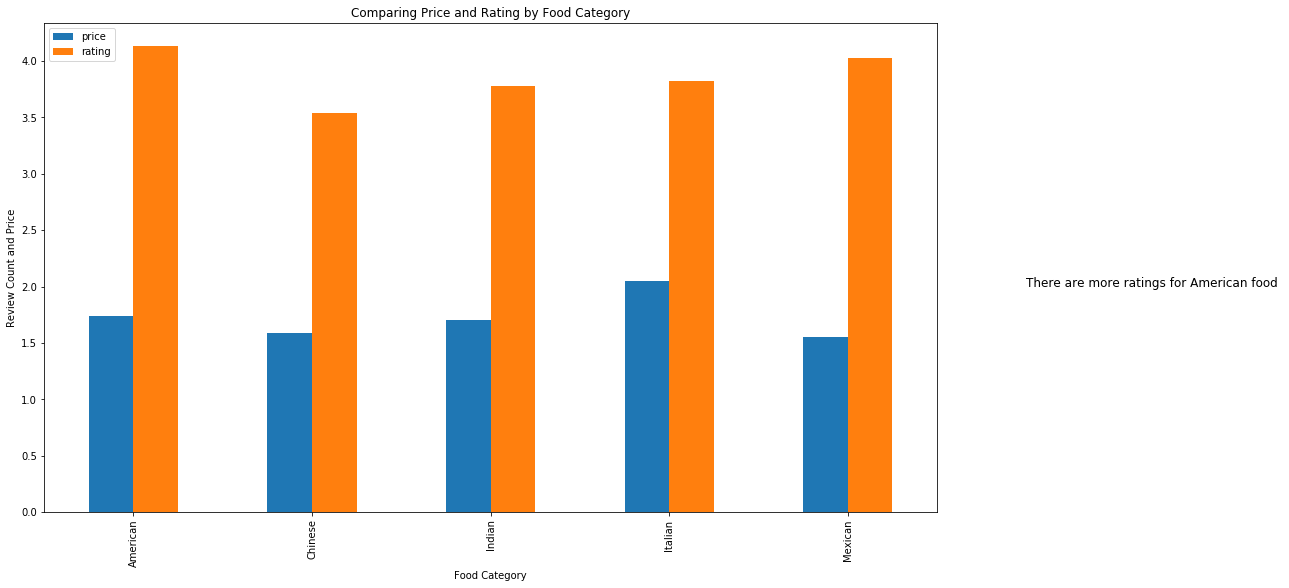

In [183]:
#Graph 1 on DataFrame comparing price and rating count by food category
newdf5.groupby("category").mean().plot(kind='bar', figsize=(16,9))
plt.xlabel("Food Category")
plt.ylabel('Review Count and Price')
plt.title('Comparing Price and Rating by Food Category')
plt.text(5, 2, 'There are more ratings for American foodand Mexican Food ' , fontsize=12)
plt.savefig("Comparing_price_and_ratingcount.png")
plt.show()

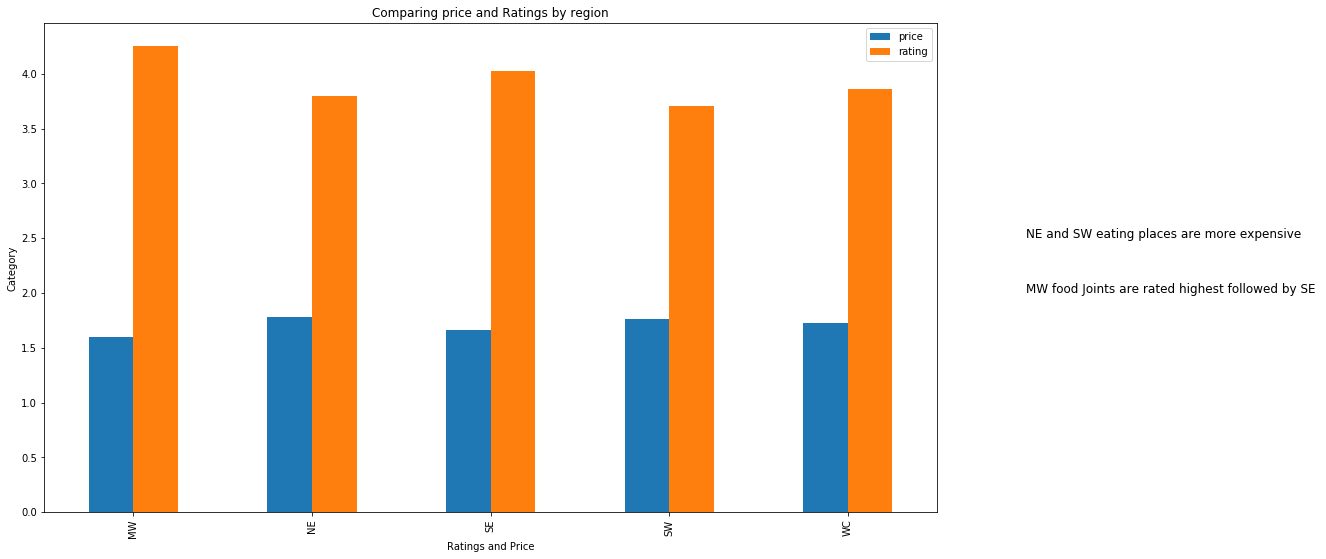

In [187]:
#Graph 2 on DataFrame comparing price and rating count by Region

newdf5.groupby("Region").mean().plot(kind='bar', figsize=(16,9))
plt.xlabel("Ratings and Price")
plt.ylabel('Category')
plt.title('Comparing price and Ratings by region')
plt.text(5, 2, 'MW food Joints are rated highest followed by SE ' , fontsize=12)
plt.text(5, 2.5, 'NE and SW eating places are more expensive ' , fontsize=12)
plt.savefig("Comparing_price_and_ratingcount.png")
plt.show()

In [176]:
# Created new Data Frame to bring in only columns that are needed
newdf6.head()

,category,Region,review_count,Incomecalc
0,American,MW,7,391.62
1,American,MW,20,391.62
2,American,MW,459,391.62
3,American,MW,10,391.62
4,American,NE,51,576.37


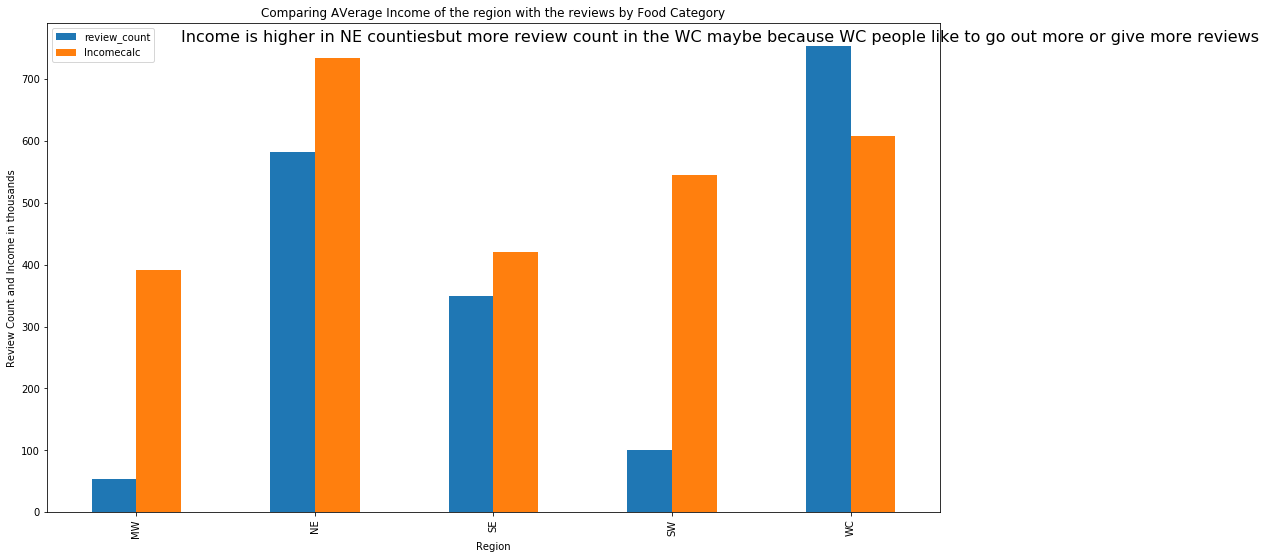

In [206]:
newdf6.groupby("Region").mean().plot(kind='bar', figsize=(16,9))
plt.xlabel("Region")
plt.ylabel('Review Count and Income in thousands')
plt.title('Comparing AVerage Income of the region with the reviews by Food Category')
plt.text(.25,760, 'Income is higher in NE countiesbut more review count in the WC maybe because WC people like to go out more or give more reviews ' , fontsize=16)

plt.savefig("Comparing Review count and Income of the.png")
plt.show()

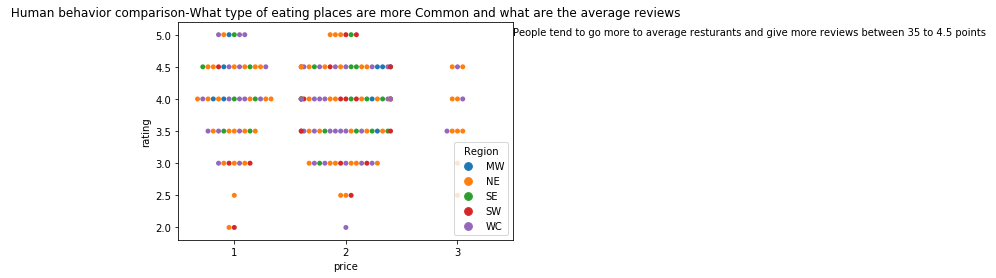

In [217]:
sns.swarmplot(x='price', y='rating', data=newdf5, 
              hue='Region')
plt.title(' Human behavior comparison-What type of eating places are more Common and what are the average reviews ')
plt.text(2.5,5, 'People tend to go more to average resturants and give more reviews between 3.5 to 4.5 points ')

plt.show()

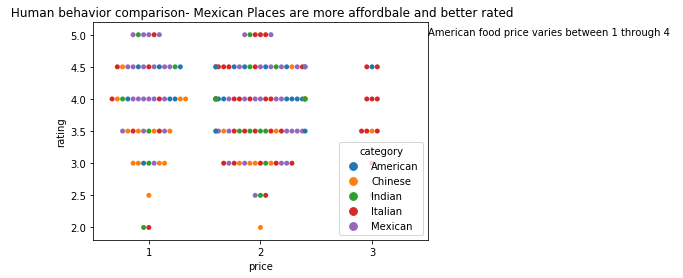

In [222]:
sns.swarmplot(x='price', y='rating', data=newdf5, 
              hue='category')
plt.title(' Human behavior comparison- Mexican Places are more affordbale and better rated')
plt.text(2.5,5, 'American food price varies between 1 through 4  ')

plt.show()

In [ ]:
comp = pd.DataFrame(res_df["category"].groupby(res_df["county_string"]).value_counts())
comp
#I HAVE NO IDEA WHAT TO DO WITH THIS

In [ ]:
CHA = CHA["category"].value_counts().reset_index()
CHA["county_string"]="Mecklenburg County, North Carolina"
CHA.columns = ["category","count","county_string"]
CHA